# gw2 1:1 Bifurcation Diagrams

# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import gw2

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, get_period, bif1d, follow_phase_diffs, phase_lock_r3d, follow_locking_3d)

from lib.rhs import _redu_c, _full
from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined)

from generate_figures import _redu_3dc_gw as _redu_3dc

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
kw_sim = {'rtol':1e-8,'atol':1e-8,'method':'LSODA'}

In [3]:
pd1 = {'v1':.84,'v2':.42,'v4':.35,'v6':.35,'v8':1,
           'k1':1,'k2':1,'k3':.7,'k4':1,'k5':.7,
           'k6':1,'k7':.35,'k8':1,'K':0.5,'kc':1,
           'n':6,'L':0,'del':0,'om':1,'om_fix':1}

In [4]:
kws1 = {'var_names':['x','y','z','v'],
        'pardict':pd1,
        'rhs':gw2.rhs,
        'coupling':gw2.coupling,
        'init':np.array([.3882,.523,1.357,.4347,24.2]),
        'TN':10000,
        'trunc_order':3,
        'z_forward':False,
        'i_forward':[False,True,False,False,False,False],
        'i_bad_dx':[False,True,False,False,False,False],
        'max_iter':50,
        'rtol':1e-12,
        'atol':1e-12,
        'rel_tol':1e-9,
        'save_fig':False,
        'lc_prominence':.05,
        'factor':0.5}

## Defs

In [5]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-9,'atol':1e-9}

In [6]:
eps_list11r = np.linspace(0.001,.1,50)
etup11 = (.001,.1,50)

In [7]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

## Initialize Response Functions

In [8]:
system1 = rsp(idx=0,model_name='gw0',**kws1)
system2 = rsp(idx=1,model_name='gw1',**kws1)

mkdir ./data/gw0/
* Loading LC data...
self.T 6.283185307179586 omfix 3.8590183230656914
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975489297
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...
mkdir ./data/gw1/
* Loading LC data...
self.T 6.283185307179586 omfix 3.8590183230656914
* Loading monodromy...
* Floquet Exponent kappa =-0.15846659975489297
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


* Computing i...


In [9]:
kw_nm = {'system1':system1,'system2':system2,'_n':('om0',1),'_m':('om1',1),
        'NH':1024,'save_fig':False}

# del=0.0

In [10]:
del11_p0 = 0
a11_p0 = nm.nmCoupling(**kw_nm, del1=del11_p0)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [11]:
kw_p0 = {'a':a11_p0,'del1':del11_p0,'recompute':False,
        'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [12]:
data_p0_list = []

In [13]:
in_dicts_p0 = [dict(init=3,eps_init=0.02,eps_final=0.11,deps=.01),
               dict(init=2.5,eps_init=0.02,eps_final=0.0005,deps=-.001)]

In [14]:
for i in range(len(in_dicts_p0)):
    in1 = in_dicts_p0[i]
    dat = follow_phase_diffs(**in1,**kw_p0)
    data_p0_list.append(dat)

fname1 td_branch_init=3_nm=11_del=0_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0_ei=0.02_ef=0.11_de=0.01.txt
fname1 td_branch_init=2.5_nm=11_del=0_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=2.5_nm=11_del=0_ei=0.02_ef=0.0005_de=-0.001.txt


In [15]:
# save hyperparameters
fname = kw_p0['bifdir']+'hyper_gw2_11_p0.txt'
hyp_inputs = np.zeros([len(in_dicts_p0),4])
for i in range(len(in_dicts_p0)):
    hyp_inputs[i,0] = in_dicts_p0[i]['init']
    hyp_inputs[i,1] = in_dicts_p0[i]['eps_init']
    hyp_inputs[i,2] = in_dicts_p0[i]['eps_final']
    hyp_inputs[i,3] = in_dicts_p0[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [16]:
data_r3d_p0_list = []

In [17]:
# find init for this branch
_,init = phase_lock_r3d([.1,0,0],a11_p0,.05,_redu_3dc)
print(init)

t_diff 8.860219080141691e-16Y=[8.86021908e-16 1.02477127e-01 1.02477127e-01]                                              
[0.     0.1025 0.1025]


In [18]:
# bot 1f
dat = follow_locking_3d(init,a11_p0,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

In [19]:
# bot 1b
dat = follow_locking_3d(init,a11_p0,(.05,.001,-.005),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p0_list.append(dat)

## Plot

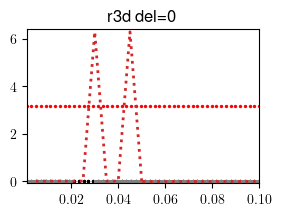

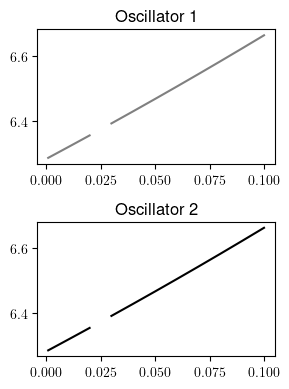

In [20]:
quick_plot_combined(a11_p0,
                    kw_f={'data_list':data_p0_list},
                    kw_r3d={'data_list':data_r3d_p0_list},
                    kw_r={'etup':etup11})

# del=0.01

In [21]:
del11_p01 = 0.01
a11_p01 = nm.nmCoupling(**kw_nm, del1=del11_p01)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


p order=1


p order=2


p order=2


p order=3


p order=3


* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...


* Computing H gw1, order=0...
* Computing H gw0, order=1...


* Computing H gw1, order=1...


* Computing H gw0, order=2...


* Computing H gw1, order=2...


* Computing H gw0, order=3...


* Computing H gw1, order=3...


## Get Branches Full

In [22]:
kw_p01 = {'a':a11_p01,'del1':del11_p01,'recompute':False,
        'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [23]:
data_p01_list = []

In [24]:
in_dicts_p01 = [dict(init=3,eps_init=0.02,eps_final=0.11,deps=.01),
                dict(init=3,eps_init=0.02,eps_final=0.0005,deps=-.001)]

In [25]:
for i in range(len(in_dicts_p01)):
    in1 = in_dicts_p01[i]
    dat = follow_phase_diffs(**in1,**kw_p01)
    data_p01_list.append(dat)

fname1 td_branch_init=3_nm=11_del=0.01_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0.01_ei=0.02_ef=0.11_de=0.01.txt
fname1 td_branch_init=3_nm=11_del=0.01_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=3_nm=11_del=0.01_ei=0.02_ef=0.0005_de=-0.001.txt


In [26]:
# save hyperparameters
fname = kw_p01['bifdir']+'hyper_gw2_11_p01.txt'
hyp_inputs = np.zeros([len(in_dicts_p01),4])
for i in range(len(in_dicts_p01)):
    hyp_inputs[i,0] = in_dicts_p01[i]['init']
    hyp_inputs[i,1] = in_dicts_p01[i]['eps_init']
    hyp_inputs[i,2] = in_dicts_p01[i]['eps_final']
    hyp_inputs[i,3] = in_dicts_p01[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [27]:
data_r3d_p01_list = []

In [28]:
# find init for this branch
_,init = phase_lock_r3d([1,0,0],a11_p01,.05,_redu_3dc)
print(init)

t_diff 0.50094164322251542, Y=[0.50094164 0.01127899 0.0840676 ]                                              
[0.5009 0.0113 0.0841]


In [29]:
# bot 1f
dat = follow_locking_3d(init,a11_p01,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p01_list.append(dat)

In [30]:
# bot 1b
dat = follow_locking_3d(init,a11_p01,(.05,.001,-.005),
                        rhs=_redu_3dc,recompute=False)
data_r3d_p01_list.append(dat)

## Plot

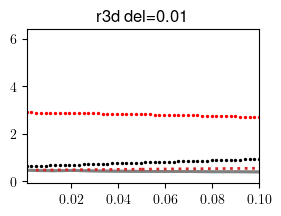

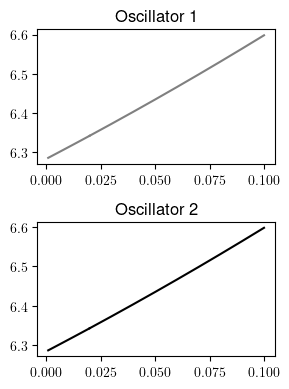

In [31]:
quick_plot_combined(a11_p01,
                    kw_f={'data_list':data_p01_list},
                    kw_r3d={'data_list':data_r3d_p01_list},
                    kw_r={'etup':etup11})

# del=0.03

In [32]:
del11_p03 = 0.03
a11_p03 = nm.nmCoupling(**kw_nm, del1=del11_p03)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


p order=0


p order=1


p order=1


p order=2


p order=2


p order=3


p order=3


* Loading H symbolic...
* Loading H symbolic...
* Computing H gw0, order=0...


* Computing H gw1, order=0...
* Computing H gw0, order=1...


* Computing H gw1, order=1...


* Computing H gw0, order=2...


* Computing H gw1, order=2...


* Computing H gw0, order=3...


* Computing H gw1, order=3...


## Get Branches Full

In [33]:
kw_p03 = {'a':a11_p03,'del1':del11_p03,'recompute':False,
        'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [34]:
data_p03_list = []

In [35]:
in_dicts_p03 = [dict(init=3,eps_init=0.02,eps_final=0.11,deps=.01),
                dict(init=3,eps_init=0.02,eps_final=0.0005,deps=-.001)]

In [36]:
for i in range(len(in_dicts_p03)):
    in1 = in_dicts_p03[i]
    dat = follow_phase_diffs(**in1,**kw_p03)
    data_p03_list.append(dat)

fname1 td_branch_init=3_nm=11_del=0.03_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0.03_ei=0.02_ef=0.11_de=0.01.txt
fname1 td_branch_init=3_nm=11_del=0.03_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=3_nm=11_del=0.03_ei=0.02_ef=0.0005_de=-0.001.txt


In [37]:
# save hyperparameters
fname = kw_p03['bifdir']+'hyper_gw2_11_p03.txt'
hyp_inputs = np.zeros([len(in_dicts_p03),4])
for i in range(len(in_dicts_p03)):
    hyp_inputs[i,0] = in_dicts_p03[i]['init']
    hyp_inputs[i,1] = in_dicts_p03[i]['eps_init']
    hyp_inputs[i,2] = in_dicts_p03[i]['eps_final']
    hyp_inputs[i,3] = in_dicts_p03[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [38]:
data_r3d_p03_list = []

In [39]:
# find init for this branch
_,init = phase_lock_r3d([1,0,0],a11_p03,.05,_redu_3dc)
print(init)

t_diff 1.25003421003761811, Y=[ 1.25003421e+00 -2.16391109e-01 -7.79517968e-04]                                              
[ 1.250e+00 -2.164e-01 -8.000e-04]


In [40]:
# bot 1f
dat = follow_locking_3d(init,a11_p03,(.05,.11,.01),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p03_list.append(dat)

eps iter 0 0.05                
t_diff 1.25003421003761671, Y=[ 1.25003421e+00 -2.16391109e-01 -7.79517968e-04]                                              
eps iter 1 0.060000000000000005                
t_diff 1.29243151700005864, Y=[ 1.29243152e+00 -2.62655418e-01 -6.78033225e-04]                                              
eps iter 2 0.07                
t_diff 1.33300127092946713, Y=[ 1.33300127e+00 -3.09547282e-01 -2.75965311e-04]                                              
eps iter 3 0.08000000000000002                
t_diff 1.37119067031502073, Y=[ 1.37119067e+00 -3.56784566e-01  5.19853839e-04]                                              
eps iter 4 0.09000000000000001                
t_diff 1.40660538515678323, Y=[ 1.40660539 -0.40410036  0.00173477]                                              
eps iter 5 0.1                
t_diff 1.43913055254030353, Y=[ 1.43913055 -0.45134845  0.00326215]                                              


t_diff 1.2924315170000586
eps iter 2 0.07                


t_diff 1.333001270929467
eps iter 3 0.08000000000000002                


t_diff 1.3711906703150207
eps iter 4 0.09000000000000001                


t_diff 1.4066053851567832
eps iter 5 0.1                


t_diff 1.4391305525403035


In [41]:
# bot 1b
dat = follow_locking_3d(init,a11_p03,(.05,.001,-.005),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p03_list.append(dat)

eps iter 0 0.05                
t_diff 1.25003421003761671, Y=[ 1.25003421e+00 -2.16391109e-01 -7.79517968e-04]                                              
eps iter 1 0.045000000000000005                
t_diff 1.22833599245646989, Y=[ 1.22833599e+00 -1.93569557e-01 -7.52632976e-04]                                              
eps iter 2 0.04000000000000001                
t_diff 1.20639915197193209, Y=[ 1.20639915e+00 -1.70985736e-01 -6.91798395e-04]                                              
eps iter 3 0.03500000000000001                
t_diff 1.18428734798544749, Y=[ 1.18428735e+00 -1.48656206e-01 -6.08586240e-04]                                              
eps iter 4 0.030000000000000013                
t_diff 1.16205669633995509, Y=[ 1.16205670e+00 -1.26592674e-01 -5.12752550e-04]                                              
eps iter 5 0.025000000000000015                
t_diff 1.13975499430172309, Y=[ 1.13975499e+00 -1.04802550e-01 -4.12164881e-04]                     

t_diff 1.206399151971932
eps iter 3 0.03500000000000001                


t_diff 1.1842873479854474
eps iter 4 0.030000000000000013                


t_diff 1.162056696339955
eps iter 5 0.025000000000000015                


t_diff 1.139754994301723
eps iter 6 0.020000000000000018                


t_diff 1.117421473071462
eps iter 7 0.01500000000000002                


t_diff 1.095086963450559
eps iter 8 0.010000000000000023                


t_diff 1.072774362473828
eps iter 9 0.005000000000000025                


t_diff 1.0504993020738704


## Plot

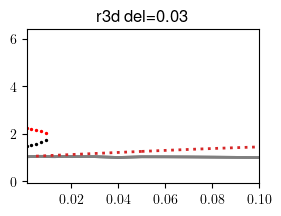

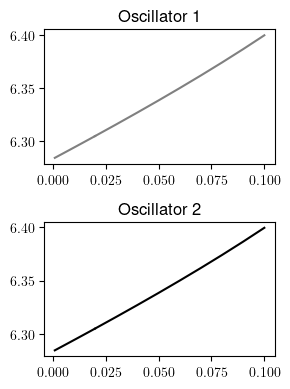

In [42]:
quick_plot_combined(a11_p03,
                    kw_f={'data_list':data_p03_list},
                    kw_r3d={'data_list':data_r3d_p03_list},
                    kw_r={'etup':etup11})

# del=0.04

In [43]:
del11_p04 = 0.04
a11_p04 = nm.nmCoupling(**kw_nm, del1=del11_p04)

pfactor 4
* Loading p symbolic...
* Loading p symbolic...
* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


* Loading H symbolic...
* Loading H symbolic...
* Loading H gw0, order=0...
* Loading H gw1, order=0...
* Loading H gw0, order=1...
* Loading H gw1, order=1...
* Loading H gw0, order=2...
* Loading H gw1, order=2...
* Loading H gw0, order=3...
* Loading H gw1, order=3...


## Get Branches Full

In [44]:
kw_p04 = {'a':a11_p04,'del1':del11_p04,'recompute':False,
        'bifdir':'bif1d_gw2/','_full_rhs':_full}

In [45]:
data_p04_list = []

In [46]:
in_dicts_p04 = [dict(init=3,eps_init=0.02,eps_final=0.11,deps=.01),
                dict(init=3,eps_init=0.02,eps_final=0.0005,deps=-.001)]

In [47]:
for i in range(len(in_dicts_p04)):
    in1 = in_dicts_p04[i]
    dat = follow_phase_diffs(**in1,**kw_p04)
    data_p04_list.append(dat)

fname1 td_branch_init=3_nm=11_del=0.04_ei=0.02_ef=0.11_de=0.01.txt
fname2 ts_branch_init=3_nm=11_del=0.04_ei=0.02_ef=0.11_de=0.01.txt
fname1 td_branch_init=3_nm=11_del=0.04_ei=0.02_ef=0.0005_de=-0.001.txt
fname2 ts_branch_init=3_nm=11_del=0.04_ei=0.02_ef=0.0005_de=-0.001.txt


In [48]:
# save hyperparameters
fname = kw_p04['bifdir']+'hyper_gw2_11_p04.txt'
hyp_inputs = np.zeros([len(in_dicts_p04),4])
for i in range(len(in_dicts_p04)):
    hyp_inputs[i,0] = in_dicts_p04[i]['init']
    hyp_inputs[i,1] = in_dicts_p04[i]['eps_init']
    hyp_inputs[i,2] = in_dicts_p04[i]['eps_final']
    hyp_inputs[i,3] = in_dicts_p04[i]['deps']
np.savetxt(fname,hyp_inputs)

## Get Branches 3D

In [49]:
data_r3d_p04_list = []

In [50]:
# find init for this branch
_,init = phase_lock_r3d([1,0,0],a11_p04,.05,_redu_3dc)
print(init)

t_diff 1.67848998539524291, Y=[ 1.67848999 -0.36208757 -0.06888956]                                              
[ 1.6785 -0.3621 -0.0689]


In [51]:
# bot 1f
dat = follow_locking_3d(init,a11_p04,(.05,.081,.01),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p04_list.append(dat)

eps iter 0 0.05                
t_diff 1.67848998539524020, Y=[ 1.67848999 -0.36208757 -0.06888956]                                              
eps iter 1 0.060000000000000005                
t_diff 1.76049743620679293, Y=[ 1.76049744 -0.44966136 -0.0876788 ]                                              
eps iter 2 0.07                
t_diff 1.86659095689764782, Y=[ 1.86659096 -0.55014329 -0.11493593]                                              
eps iter 3 0.08000000000000002                


t_diff 1.8665909568976478
eps iter 3 0.08000000000000002                


In [52]:
# bot 1b
dat = follow_locking_3d(init,a11_p04,(.05,.001,-.005),
                        rhs=_redu_3dc,recompute=True)
data_r3d_p04_list.append(dat)

eps iter 0 0.05                
t_diff 1.67848998539524020, Y=[ 1.67848999 -0.36208757 -0.06888956]                                              
eps iter 1 0.045000000000000005                
t_diff 1.63907989860157494, Y=[ 1.6390799  -0.32065567 -0.06050723]                                              
eps iter 2 0.04000000000000001                
t_diff 1.59990448097709113, Y=[ 1.59990448 -0.2805129  -0.05253282]                                              
eps iter 3 0.03500000000000001                
t_diff 1.56085850008128913, Y=[ 1.5608585  -0.24159252 -0.04490514]                                              
eps iter 4 0.030000000000000013                
t_diff 1.52199566986590474, Y=[ 1.52199567 -0.20385727 -0.03760156]                                              
eps iter 5 0.025000000000000015                
t_diff 1.48343070119040074, Y=[ 1.4834307  -0.16727322 -0.03061272]                                              
eps iter 6 0.020000000000000018               

t_diff 1.6390798986015749
eps iter 2 0.04000000000000001                


t_diff 1.599904480977091
eps iter 3 0.03500000000000001                


t_diff 1.560858500081289
eps iter 4 0.030000000000000013                


t_diff 1.5219956698659047
eps iter 5 0.025000000000000015                
t_diff 1.4834307011904007
eps iter 6 0.020000000000000018                


t_diff 1.4452851479750217
eps iter 7 0.01500000000000002                


t_diff 1.407659423765356
eps iter 8 0.010000000000000023                
t_diff 1.370620739493683
eps iter 9 0.005000000000000025                


t_diff 1.3342003676212402


## Plot

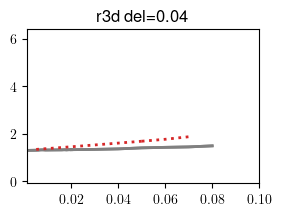

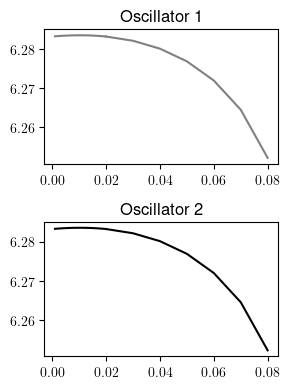

In [53]:
quick_plot_combined(a11_p04,
                    kw_f={'data_list':data_p04_list},
                    kw_r3d={'data_list':data_r3d_p04_list},
                    kw_r={'etup':etup11})

## Sims

In [54]:
# coupling and init
eps11_p04 = 0.09
th_init11_p04 = 2

In [55]:
# sim params
dt = .01;T_p04=1000
t11_p04 = np.arange(0,T_p04,dt)
args11_p04 = {'args':(a11_p04,eps11_p04,del11_p04),
             't_eval':t11_p04,**kw_sim,'dense_output':True}

In [56]:
# initialize and run full
y0a = a11_p04.system1.lc['dat'][int((th_init11_p04/(2*np.pi)) * a11_p04.system1.TN),:]
y0b = a11_p04.system2.lc['dat'][int((0/(2*np.pi)) * a11_p04.system2.TN),:]

y0_p04 = np.array([y0a,y0b]).flatten()

solf11_p04 = solve_ivp(_full,[0,t11_p04[-1]],
                        y0_p04, **args11_p04)

In [57]:
solr11_p04 = solve_ivp(_redu_c,[0,t11_p04[-1]],
                     [th_init11_p04],**args11_p04)

In [58]:
# solr12b_p04 = solve_ivp(_redu_3dc,[0,t11_p04[-1]],
#                     [th_init11_p04,0,0],**args11_p04)

In [59]:
tp12a_p04, phase12a_p04 = get_phase(t11_p04,solf11_p04.y.T[:,:4],
                            skipn=50,system1=a11_p04.system1)
tp12b_p04, phase12b_p04 = get_phase(t11_p04,solf11_p04.y.T[:,4:],
                            skipn=50,system1=a11_p04.system2)

(-0.5, 6.783185307179586)

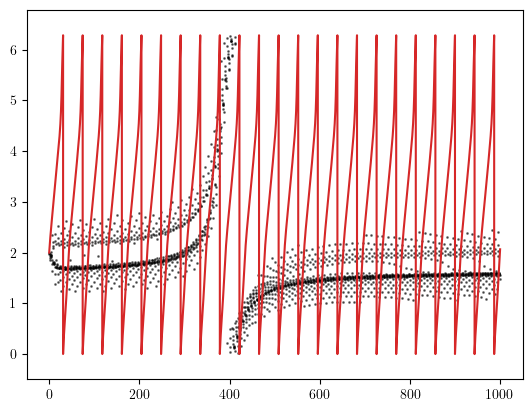

In [60]:
fig,axs = plt.subplots()
y = np.mod(phase12a_p04 - a11_p04.om*phase12b_p04,2*np.pi)
axs.scatter(tp12a_p04,y,s=1,alpha=.5,color='black')

axs.plot(t11_p04,np.mod(solr11_p04.y.T,2*np.pi),
         color='tab:red')

axs.set_ylim(-.5,2*np.pi+.5)